# ResNet from Scratch

I've implemented ResNet from scratch (it was a little tricky compared to some of the other reimplementations I've done) and want to try it out to first see if the forward / backward passes are working fine and then try it against a vision dataset (CIFAR10).

I'm going to work with ResNet18 here because my compute is pretty limited (just my laptop).

I'll start with the imports / setting up env.

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # resnet/ is up one level

And now let's do our main imports. I'm calling in torchvision mainly for the dataset functionality that they provide.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from resnet.resnet import resnet18
from resnet.utils import initialize_weights
from tqdm import tqdm

Before we move on let's check that all the test cases are passing.

In [4]:
import subprocess
import os

os.chdir("../tests")
result = subprocess.run(["pytest", "test_blocks.py"], capture_output=True, text=True)

print(result.stdout)
print(result.stderr)

result = subprocess.run(["pytest", "test_resnet.py"], capture_output=True, text=True)

print(result.stdout)
print(result.stderr)

============================= test session starts ==============================
platform darwin -- Python 3.13.2, pytest-8.4.1, pluggy-1.6.0
rootdir: /Users/akhilvreddy/Documents/resnet-reimplementation
configfile: pytest.ini
collected 2 items

test_blocks.py ..                                                        [100%]

============================== 2 passed in 0.43s ===============================


============================= test session starts ==============================
platform darwin -- Python 3.13.2, pytest-8.4.1, pluggy-1.6.0
rootdir: /Users/akhilvreddy/Documents/resnet-reimplementation
configfile: pytest.ini
collected 2 items

test_resnet.py ..                                                        [100%]

============================== 2 passed in 0.54s ===============================




I thought about using MNIST first (to just check that the model was learning) but with the image sizes being different (and CNNs being overkill) I decided to just stick to CIFAR.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

classes = train_data.classes

We can now instantiate the model.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(num_classes=10).to(device)
initialize_weights(model)

And the loss function / optimizer.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

We can now set it to train. I think 3 epochs should be okay to see if the model is learning. I also added early stopping because this was taking a little while to train and I felt that the training was going to flatline after a bit.

In [ ]:
from tqdm import tqdm

epochs = 3
early_stopping_threshold = 0.3
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)

    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")

    if avg_loss < early_stopping_threshold:
        print(f"Early stopping triggered at epoch {epoch+1} (loss < {early_stopping_threshold})")
        break

Epoch [1/3]: 100%|██████████| 782/782 [23:32<00:00,  1.81s/it, loss=1.48]    


Epoch 1/3 - Avg Loss: 1.3872


Epoch [2/3]: 100%|██████████| 782/782 [08:38<00:00,  1.51it/s, loss=1.24]   


Epoch 2/3 - Avg Loss: 0.9923


Epoch [3/3]: 100%|██████████| 782/782 [04:38<00:00,  2.81it/s, loss=0.701]

Epoch 3/3 - Avg Loss: 0.8163


Here's what the learning curve looks like, given that we had early stopping.

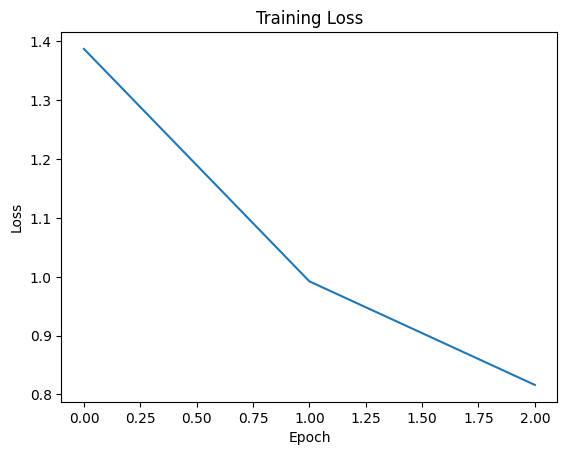

In [9]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Our loss wasn't too low (0.8) but I want to see how it will hold out against the test set

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating", leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(acc=100 * correct / total)

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

Evaluating: 100%|██████████| 157/157 [00:50<00:00,  3.10it/s, acc=70.4]

✅ Test Accuracy: 70.36%


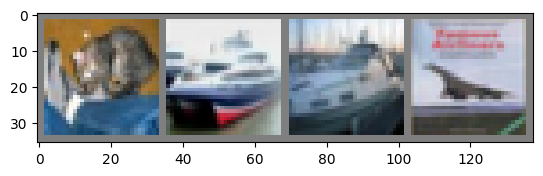

Predicted: ['cat', 'ship', 'airplane', 'airplane']
Actual:    ['cat', 'ship', 'ship', 'airplane']


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

model.eval()
images = images.to(device)
outputs = model(images[:4])
_, preds = torch.max(outputs, 1)

print("Predicted:", [classes[p] for p in preds])
print("Actual:", [classes[l] for l in labels[:4]])

This isn't bad at all in my opinion. ResNet18 with 3 epochs was able to reach 70% accuracy and we have proof. The first two pictures do look like a car and ship and the last one does look like an airplane which our model correctly predicted (out of many labels). I'm confident that with more epochs this model would perform way better. 